In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from skimage.util import random_noise
from skimage.filters import gaussian
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [80]:
# Paths
train_dir = "/kaggle/input/catsanddogs/Dog vs Cat Dataset and Code/dataset/training_set"
test_dir = "/kaggle/input/catsanddogs/Dog vs Cat Dataset and Code/dataset/test_set"

In [87]:
# Parameters
img_size = 128
batch_size = 32

# Function to apply noise (salt-and-pepper or motion blur)
def add_corruption(image, noise_type='salt_and_pepper', intensity=0.05):
    if noise_type == 'salt_and_pepper':
        return random_noise(image, mode='s&p', amount=intensity)
    elif noise_type == 'motion_blur':
        return gaussian(image, sigma=intensity, multichannel=True)
    return image

def load_images_from_folder(folder, label):
    images = []
    labels = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        if os.path.isfile(img_path):  # Ensure it's a file
            try:
                img = load_img(img_path, target_size=(img_size, img_size))
                img_array = img_to_array(img) / 255.0
                corrupted_img = add_corruption(img_array, noise_type='salt_and_pepper', intensity=0.02)
                images.append(corrupted_img)
                labels.append(label)
            except Exception as e:
                print(f"Error loading image {img_path}: {e}")
    print(f"Loaded {len(images)} images from {folder}")
    return images, labels

In [84]:
# Load testing data
cat_test_images, cat_test_labels = load_images_from_folder(os.path.join(test_dir, 'cats'), label=0)
dog_test_images, dog_test_labels = load_images_from_folder(os.path.join(test_dir, 'dogs'), label=1)
X_val = np.array(cat_test_images + dog_test_images)
y_val = np.array(cat_test_labels + dog_test_labels)

In [ ]:
# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
datagen.fit(X_train)

In [ ]:
# Define the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_size, img_size, 3)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=SGD(learning_rate=0.01, momentum=0.9),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=batch_size),
    epochs=20,
    validation_data=(X_val, y_val)
)

In [ ]:
# Plot Accuracy and Loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], 'bo-', label='Train Accuracy')
plt.plot(history.history['val_accuracy'], 'ro-', label='Validation Accuracy')
plt.legend()
plt.title('Accuracy Over Epochs')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], 'bo-', label='Train Loss')
plt.plot(history.history['val_loss'], 'ro-', label='Validation Loss')
plt.legend()
plt.title('Loss Over Epochs')
plt.show()

In [ ]:
# Evaluate the model and display confusion matrix
loss, accuracy = model.evaluate(X_val, y_val)
print(f'Validation Accuracy: {accuracy:.4f}')
y_pred = (model.predict(X_val) > 0.5).astype(int)
cm = confusion_matrix(y_val, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Cat", "Dog"])
disp.plot(cmap="Blues")
plt.show()

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import cv2
from scipy.signal import convolve2d

In [38]:
# Define paths in Kaggle
dataset_path = "/kaggle/input/catsanddogs/Dog vs Cat Dataset and Code/dataset"
train_dir = os.path.join(dataset_path, "training_set")
test_dir = os.path.join(dataset_path, "test_set")

In [46]:

print("Train Directory Contents:")
print(os.listdir(train_dir))

print("Test Directory Contents:")
print(os.listdir(test_dir))


Train Directory Contents:
['dogs', 'cats']
Test Directory Contents:
['dogs', 'cats']


In [40]:
# Image parameters
img_size = 128
batch_size = 32

def load_images_from_folder(folder, label):
    images = []
    labels = []
    for root, _, files in os.walk(folder):  # os.walk allows recursive traversal
        for filename in files:
            img_path = os.path.join(root, filename)
            
            # Skip non-image files if any
            if not filename.lower().endswith(('.png', '.jpg', '.jpeg')):
                print(f"Skipping non-image file: {img_path}")
                continue
            
            # Process image files
            img = load_img(img_path, target_size=(img_size, img_size))
            img_array = img_to_array(img) / 255.0  # Normalize images
            images.append(img_array)
            labels.append(label)
    
    return images, labels


# 1. Denoising with Median Filter (Salt-and-Pepper Noise)
Median filtering is effective for removing salt-and-pepper noise while preserving edges.

In [41]:
def remove_salt_and_pepper_noise(image):
    """
    Applies a median filter to remove salt-and-pepper noise.
    
    Args:
        image: Input image with noise (numpy array).
    
    Returns:
        Denoised image.
    """
    denoised_image = cv2.medianBlur(image, 3)  # Kernel size 3
    return denoised_image


# 2. Deblurring with Wiener Filter (Motion Blur)
A Wiener filter can reduce motion blur by estimating the blur kernel.

In [42]:
def wiener_filter(image, kernel_size=5, noise_var=0.1):
    """
    Applies a Wiener filter to reduce motion blur.
    
    Args:
        image: Input image with motion blur (numpy array).
        kernel_size: Size of the motion blur kernel.
        noise_var: Estimated noise variance.
    
    Returns:
        Deblurred image.
    """
    kernel = np.ones((kernel_size, kernel_size)) / kernel_size**2  # Uniform blur kernel
    mean_img = convolve2d(image, kernel, mode='same')
    variance_img = convolve2d(image**2, kernel, mode='same') - mean_img**2
    variance_img = np.maximum(variance_img, noise_var)
    wiener_image = mean_img + (image - mean_img) / variance_img
    return np.clip(wiener_image, 0, 1)


# 3. Preprocessing Pipeline
Combine these techniques into a preprocessing function:

In [43]:
def preprocess_image(image, noise_type):
    """
    Preprocesses an image to handle noise or blur based on the type.
    
    Args:
        image: Input image (numpy array).
        noise_type: Type of noise ('salt_pepper' or 'motion_blur').
    
    Returns:
        Preprocessed image.
    """
    if noise_type == 'salt_pepper':
        return remove_salt_and_pepper_noise(image)
    elif noise_type == 'motion_blur':
        return wiener_filter(image)
    else:
        raise ValueError("Unsupported noise type. Use 'salt_pepper' or 'motion_blur'.")


# 4. Apply Preprocessing to Dataset
Assume your training and test directories have noisy images.

In [50]:
def preprocess_dataset(main_folder, noise_type):
    images = []
    subfolder = os.path.join(main_folder, noise_type)
    print(f"Processing folder: {subfolder}")  # Debugging folder path
    for filename in os.listdir(subfolder):  # Loop over all files in the subfolder
        img_path = os.path.join(subfolder, filename)
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):  # Only process image files
            try:
                img = load_img(img_path, target_size=(img_size, img_size))
                img_array = img_to_array(img) / 255.0  # Normalize images
                preprocessed_img = preprocess_image(img_array, noise_type)
                images.append(preprocessed_img)
            except Exception as e:
                print(f"Error loading image {img_path}: {e}")
        else:
            print(f"Skipping non-image file: {filename}")
    return np.array(images)


In [57]:
subfolder = "/kaggle/input/catsanddogs/Dog vs Cat Dataset and Code/dataset/test_set/cats/motion_blur/"

In [58]:
print(os.listdir(subfolder))

['cat.4414.jpg', 'cat.4420.jpg', 'cat.4880.jpg', 'cat.4326.jpg', 'cat.4620.jpg', 'cat.4071.jpg', 'cat.4641.jpg', 'cat.4958.jpg', 'cat.4139.jpg', 'cat.4672.jpg', 'cat.4403.jpg', 'cat.4485.jpg', 'cat.4841.jpg', 'cat.4901.jpg', 'cat.4476.jpg', 'cat.4267.jpg', 'cat.4473.jpg', 'cat.4387.jpg', 'cat.4784.jpg', 'cat.4172.jpg', 'cat.4594.jpg', 'cat.4949.jpg', 'cat.4970.jpg', 'cat.4165.jpg', 'cat.4273.jpg', 'cat.4769.jpg', 'cat.4033.jpg', 'cat.4560.jpg', 'cat.4566.jpg', 'cat.4174.jpg', 'cat.4101.jpg', 'cat.4147.jpg', 'cat.4491.jpg', 'cat.4920.jpg', 'cat.4247.jpg', 'cat.4468.jpg', 'cat.4206.jpg', 'cat.5000.jpg', 'cat.4914.jpg', 'cat.4050.jpg', 'cat.4600.jpg', 'cat.4259.jpg', 'cat.4439.jpg', 'cat.4913.jpg', 'cat.4300.jpg', 'cat.4047.jpg', 'cat.4817.jpg', 'cat.4036.jpg', 'cat.4747.jpg', 'cat.4410.jpg', 'cat.4576.jpg', 'cat.4939.jpg', 'cat.4828.jpg', 'cat.4052.jpg', 'cat.4498.jpg', 'cat.4231.jpg', 'cat.4877.jpg', 'cat.4363.jpg', 'cat.4240.jpg', 'cat.4245.jpg', 'cat.4382.jpg', 'cat.4355.jpg', 'cat.40

In [59]:
test_image_path = os.path.join(subfolder, "/kaggle/input/catsanddogs/Dog vs Cat Dataset and Code/dataset/test_set/cats/motion_blur/cat.4001.jpg")  # Replace with a real filename
try:
    img = load_img(test_image_path, target_size=(img_size, img_size))
    print("Image loaded successfully.")
except Exception as e:
    print(f"Error loading image: {e}")


Image loaded successfully.


In [62]:
def preprocess_dataset(subfolder):
    images = []
    for filename in os.listdir(subfolder):
        img_path = os.path.join(subfolder, filename)
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):  # Process only image files
            try:
                img = load_img(img_path, target_size=(128, 128))  # Adjust target size as needed
                img_array = img_to_array(img) / 255.0  # Normalize images
                images.append(img_array)
            except Exception as e:
                print(f"Error loading image {img_path}: {e}")
        else:
            print(f"Skipping non-image file: {filename}")
    return np.array(images)


In [63]:
train_cats_motion_blur = preprocess_dataset("/kaggle/input/catsanddogs/Dog vs Cat Dataset and Code/dataset/training_set/cats/motion_blur/")
test_cats_motion_blur = preprocess_dataset("/kaggle/input/catsanddogs/Dog vs Cat Dataset and Code/dataset/test_set/cats/motion_blur/")


In [70]:
train_dogs_motion_blur_path = "/kaggle/input/catsanddogs/Dog vs Cat Dataset and Code/dataset/training_set/dogs/motion_blur"
test_dogs_motion_blur_path = "/kaggle/input/catsanddogs/Dog vs Cat Dataset and Code/dataset/test_set/dogs/motion_blur"


In [65]:
def preprocess_dataset(subfolder):
    images = []
    for filename in os.listdir(subfolder):
        img_path = os.path.join(subfolder, filename)
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):  # Process only image files
            try:
                img = load_img(img_path, target_size=(128, 128))  # Adjust target size as needed
                img_array = img_to_array(img) / 255.0  # Normalize images
                images.append(img_array)
            except Exception as e:
                print(f"Error loading image {img_path}: {e}")
        else:
            print(f"Skipping non-image file: {filename}")
    return np.array(images)


In [66]:
# Preprocess motion blur images for dogs
train_dogs_motion_blur = preprocess_dataset(train_dogs_motion_blur_path)
test_dogs_motion_blur = preprocess_dataset(test_dogs_motion_blur_path)

# Verify
print(f"Processed {len(train_dogs_motion_blur)} training images for dogs.")
print(f"Processed {len(test_dogs_motion_blur)} testing images for dogs.")


Processed 4000 training images for dogs.
Processed 1000 testing images for dogs.


In [67]:
# Combine cats and dogs datasets for training
X_train = np.concatenate([train_cats_motion_blur, train_dogs_motion_blur], axis=0)
y_train = np.array([0] * len(train_cats_motion_blur) + [1] * len(train_dogs_motion_blur))  # 0 for cats, 1 for dogs

# Combine cats and dogs datasets for testing
X_test = np.concatenate([test_cats_motion_blur, test_dogs_motion_blur], axis=0)
y_test = np.array([0] * len(test_cats_motion_blur) + [1] * len(test_dogs_motion_blur))  # 0 for cats, 1 for dogs

# Verify
print(f"Training dataset size: {X_train.shape}")
print(f"Testing dataset size: {X_test.shape}")


Training dataset size: (8000, 128, 128, 3)
Testing dataset size: (2000, 128, 128, 3)


In [75]:
# Load training images for both classes
cat_train_images, cat_train_labels = load_images_from_folder(os.path.join(train_dir, 'cats'), label=0)
dog_train_images, dog_train_labels = load_images_from_folder(os.path.join(train_dir, 'dogs'), label=1)

# Combine training data
X_train = np.array(cat_train_images + dog_train_images)
y_train = np.array(cat_train_labels + dog_train_labels)

# Load test images for both classes
cat_test_images, cat_test_labels = load_images_from_folder(os.path.join(test_dir, 'cats'), label=0)
dog_test_images, dog_test_labels = load_images_from_folder(os.path.join(test_dir, 'dogs'), label=1)

# Combine test data
X_val = np.array(cat_test_images + dog_test_images)
y_val = np.array(cat_test_labels + dog_test_labels)

plt.figure(figsize=(10, 10))

# Find indexes for the first few images of each class
cat_indexes = np.where(y_train == 0)[0][:5]  # First 5 cat images
dog_indexes = np.where(y_train == 1)[0][:4]  # First 4 dog images

# Combine indexes to get a mix of cat and dog images
sample_indexes = np.concatenate([cat_indexes, dog_indexes])

# Display the images
for i, idx in enumerate(sample_indexes):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(X_train[idx])
    plt.title("Cat" if y_train[idx] == 0 else "Dog")
    plt.axis("off")

plt.show()

<Figure size 1000x1000 with 0 Axes>

In [76]:
# Define the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_size, img_size, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dropout(0.5),
    Dense(512, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)
callbacks = [early_stopping, reduce_lr]

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=batch_size,
    validation_data=(X_val, y_val),
    callbacks=callbacks
)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │    12,845,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,939,329 (49.36 MB)

 Trainable params: 12,939,329 (49.36 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20


ValueError: Exception encountered when calling Sequential.call().

[1mInvalid input shape for input Tensor("data:0", shape=(32,), dtype=float32). Expected shape (None, 128, 128, 3), but input has incompatible shape (32,)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(32,), dtype=float32)
  • training=True
  • mask=None

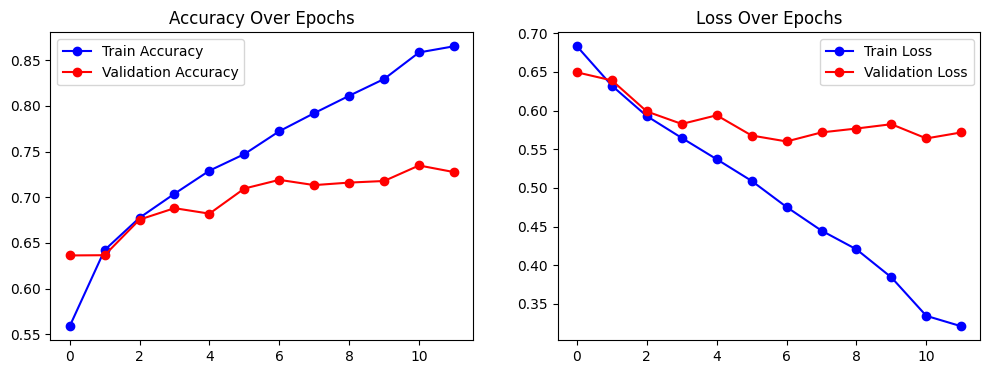

In [17]:
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], 'bo-', label='Train Accuracy')
plt.plot(history.history['val_accuracy'], 'ro-', label='Validation Accuracy')
plt.legend()
plt.title('Accuracy Over Epochs')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], 'bo-', label='Train Loss')
plt.plot(history.history['val_loss'], 'ro-', label='Validation Loss')
plt.legend()
plt.title('Loss Over Epochs')
plt.show()


In [18]:
# Save the model
model.save('dog_cat_classifier.h5')

In [19]:
# Evaluate the model on the validation set
loss, accuracy = model.evaluate(X_val, y_val)
print(f'Accuracy: {accuracy:.4f}')
print(f'Loss: {loss:.4f}')

125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7676 - loss: 0.4986
Accuracy: 0.7190
Loss: 0.5600


125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


<Figure size 1600x800 with 0 Axes>

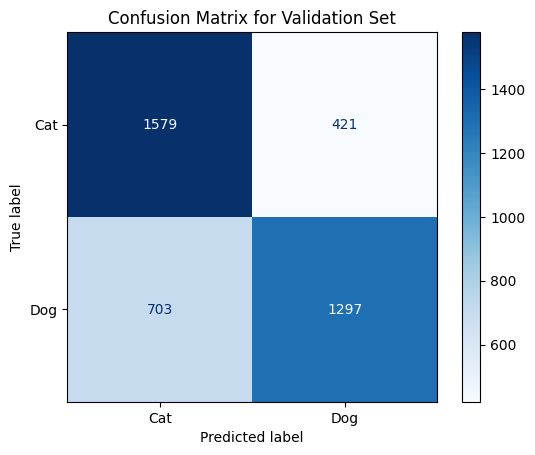

In [20]:
# Confusion Matrix
# Step 1: Make predictions on the validation set
y_pred = model.predict(X_val)
y_pred = (y_pred > 0.5).astype(int)  # Convert probabilities to binary labels (0 or 1)
# Generate confusion matrix
cm = confusion_matrix(y_val, y_pred)
# Display the confusion matrix
plt.figure(figsize=(16, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Cat", "Dog"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix for Validation Set")
plt.show()

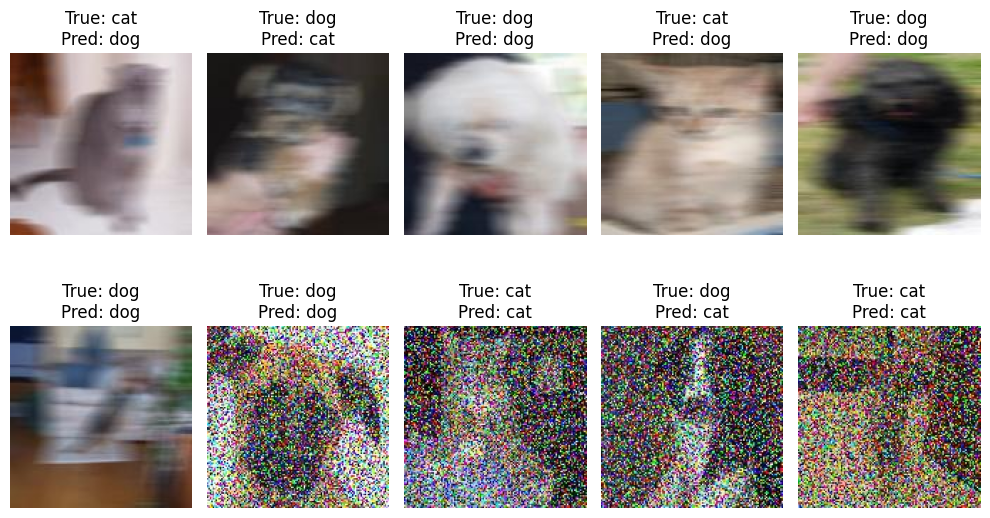

In [21]:
# Random Predictions
# Define the number of samples and rows
num_samples = 10  # Total number of samples to display
num_cols = 5  # Number of columns per row
num_rows = (num_samples + num_cols - 1) // num_cols  # Calculate required rows
# Select random indices from the test set
random_indices = np.random.choice(len(X_val), num_samples, replace=False)
# Plot the random predictions
plt.figure(figsize=(10, num_rows * 3))
for i, idx in enumerate(random_indices):
    plt.subplot(num_rows, num_cols, i + 1)
    plt.imshow(X_val[idx], cmap='gray')  # Display the image
    # Get true and predicted labels
    true_label = 'dog' if y_val[idx] == 1 else 'cat'  # True label
    pred_label = 'dog' if y_pred[idx][0] == 1 else 'cat'  # Predicted label
    # Title for true and predicted labels
    plt.title(f'True: {true_label}\nPred: {pred_label}')
    plt.axis('off')
plt.tight_layout()
plt.show()

#%%